In [1]:
# conda env = data_driven_fep_rel
import BioSimSpace as BSS
import glob
from rdkit import Chem
import csv
from sklearn.preprocessing import minmax_scale
import numpy as np

# to navigate the OS:
import os
import shutil


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
  return f(*args, **kwds)
100%|██████████| 9/9 [01:26<00:00,  9.61s/it]


In [2]:
def getLigName(path):
    """Cleans up a path, retrieves the ligand name."""
    return path.split("/")[-1].replace(".sdf","")

In [3]:
def scaleArray(arr):
    """Scales an array to be the inverse in the range [0-1].
    This is needed because SEM predictions (0 good, 1 bad) are the inverse of LOMAP-Score (0 bad, 1 good). """
    
    # normalise to the range 0-1.
    return minmax_scale(1 /  np.array(arr), feature_range=(0,1))

# Nich's Code - Taking folder of cluster molecules, prepare files for LOMAP and RBFENN

In [12]:
cluster_dir_name = "cls-22-06-28/cls12/"
path_to_cluster = f"clusters/{cluster_dir_name}"

network_directory = f"networks/{cluster_dir_name}"
cluster_pairs_input = f"{network_directory}cluster_pairs.csv"
sem_predictions = f"{network_directory}sem_preds.csv"

# Generate Cluster Pairs (cluster_pairs.csv)

In [13]:
from itertools import combinations # handy function to create pairs of items in lists.
import os

ligand_file_paths = glob.glob(f"{path_to_cluster}*.sdf")

if not os.path.exists(network_directory):
    os.makedirs(network_directory)
    
with open(cluster_pairs_input, "w") as writefile:
    writer = csv.writer(writefile)

    # first get all combinations of ligands paths.
    all_pairs = list(combinations(ligand_file_paths, 2))

    # loop over the pairs while writing out lines.
    for a, b in all_pairs:
        writer.writerow([a, b])

        # also write the inverse pair, itertools.combinations only grabs A->B.
        writer.writerow([b, a])

# Take cluster pairs, generate RBFENN predictions, save in sem_predictions file

In [8]:
os.system(f'python predict_sf.py -i {cluster_pairs_input} -o {sem_predictions}')


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.


Building model..
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_features_0 (InputLayer)    [(None, 29)]         0                                            
__________________________________________________________________________________________________
bond_features_0 (InputLayer)    [(None, 7)]          0                                            
__________________________________________________________________________________________________
pair_in

0

# Jenke's Code - DO NOT ALTER

In [14]:
links_file_name = network_directory+"links_file.in"
work_dir = network_directory+"runner_work_dir"
# first clean up if needed. BSS seems to mess up if some files are already there when it starts the below procedure.
if os.path.exists(work_dir) and os.path.isdir(work_dir):
    shutil.rmtree(work_dir)
    
if os.path.exists(links_file_name):
    os.remove(links_file_name)

In [28]:
import glob
ligands_rdkit = [Chem.SDMolSupplier(x)[0] for x in glob.glob(f"{path_to_cluster}*.sdf")]
ligand_names = [getLigName(x) for x in glob.glob(f"{path_to_cluster}*.sdf")]

# add indexing to ligand_names as a dict.
ligand_names_dict = {}
id_to_ligand_dict = {}
for i, lig in enumerate(ligand_names):
    j = "{0:0=3d}".format(i) # make the indexing have 3 digits, i.e. 001, 002, 003 etc.
    ligand_names_dict[lig] = f"{j}_{lig}.sdf"
    id_to_ligand_dict[i] = lig

In [20]:
true_perts = []
true_sems = []

with open(sem_predictions, "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    # parse the SEM predictions file. Put the relevant data into separate lists.
    for row in reader:
        true_perts.append([ligand_names_dict[getLigName(row[0])], ligand_names_dict[getLigName(row[1])]])
        true_sems.append(float(row[-1]))
# scale the SEM predictions to fit the LOMAP-Score form.
scaled_sems = scaleArray(true_sems)

In [21]:
with open(links_file_name, "w") as writefile:
    writer = csv.writer(writefile, delimiter =" ")
    # write a 'links file' that contains all combinations of 
    # ligands and their SEM scores (that will replace LOMAP-Score.)
    for (a,b), value in zip(true_perts, scaled_sems):
        writer.writerow([a, b, value])

# Generate RBFENN Network

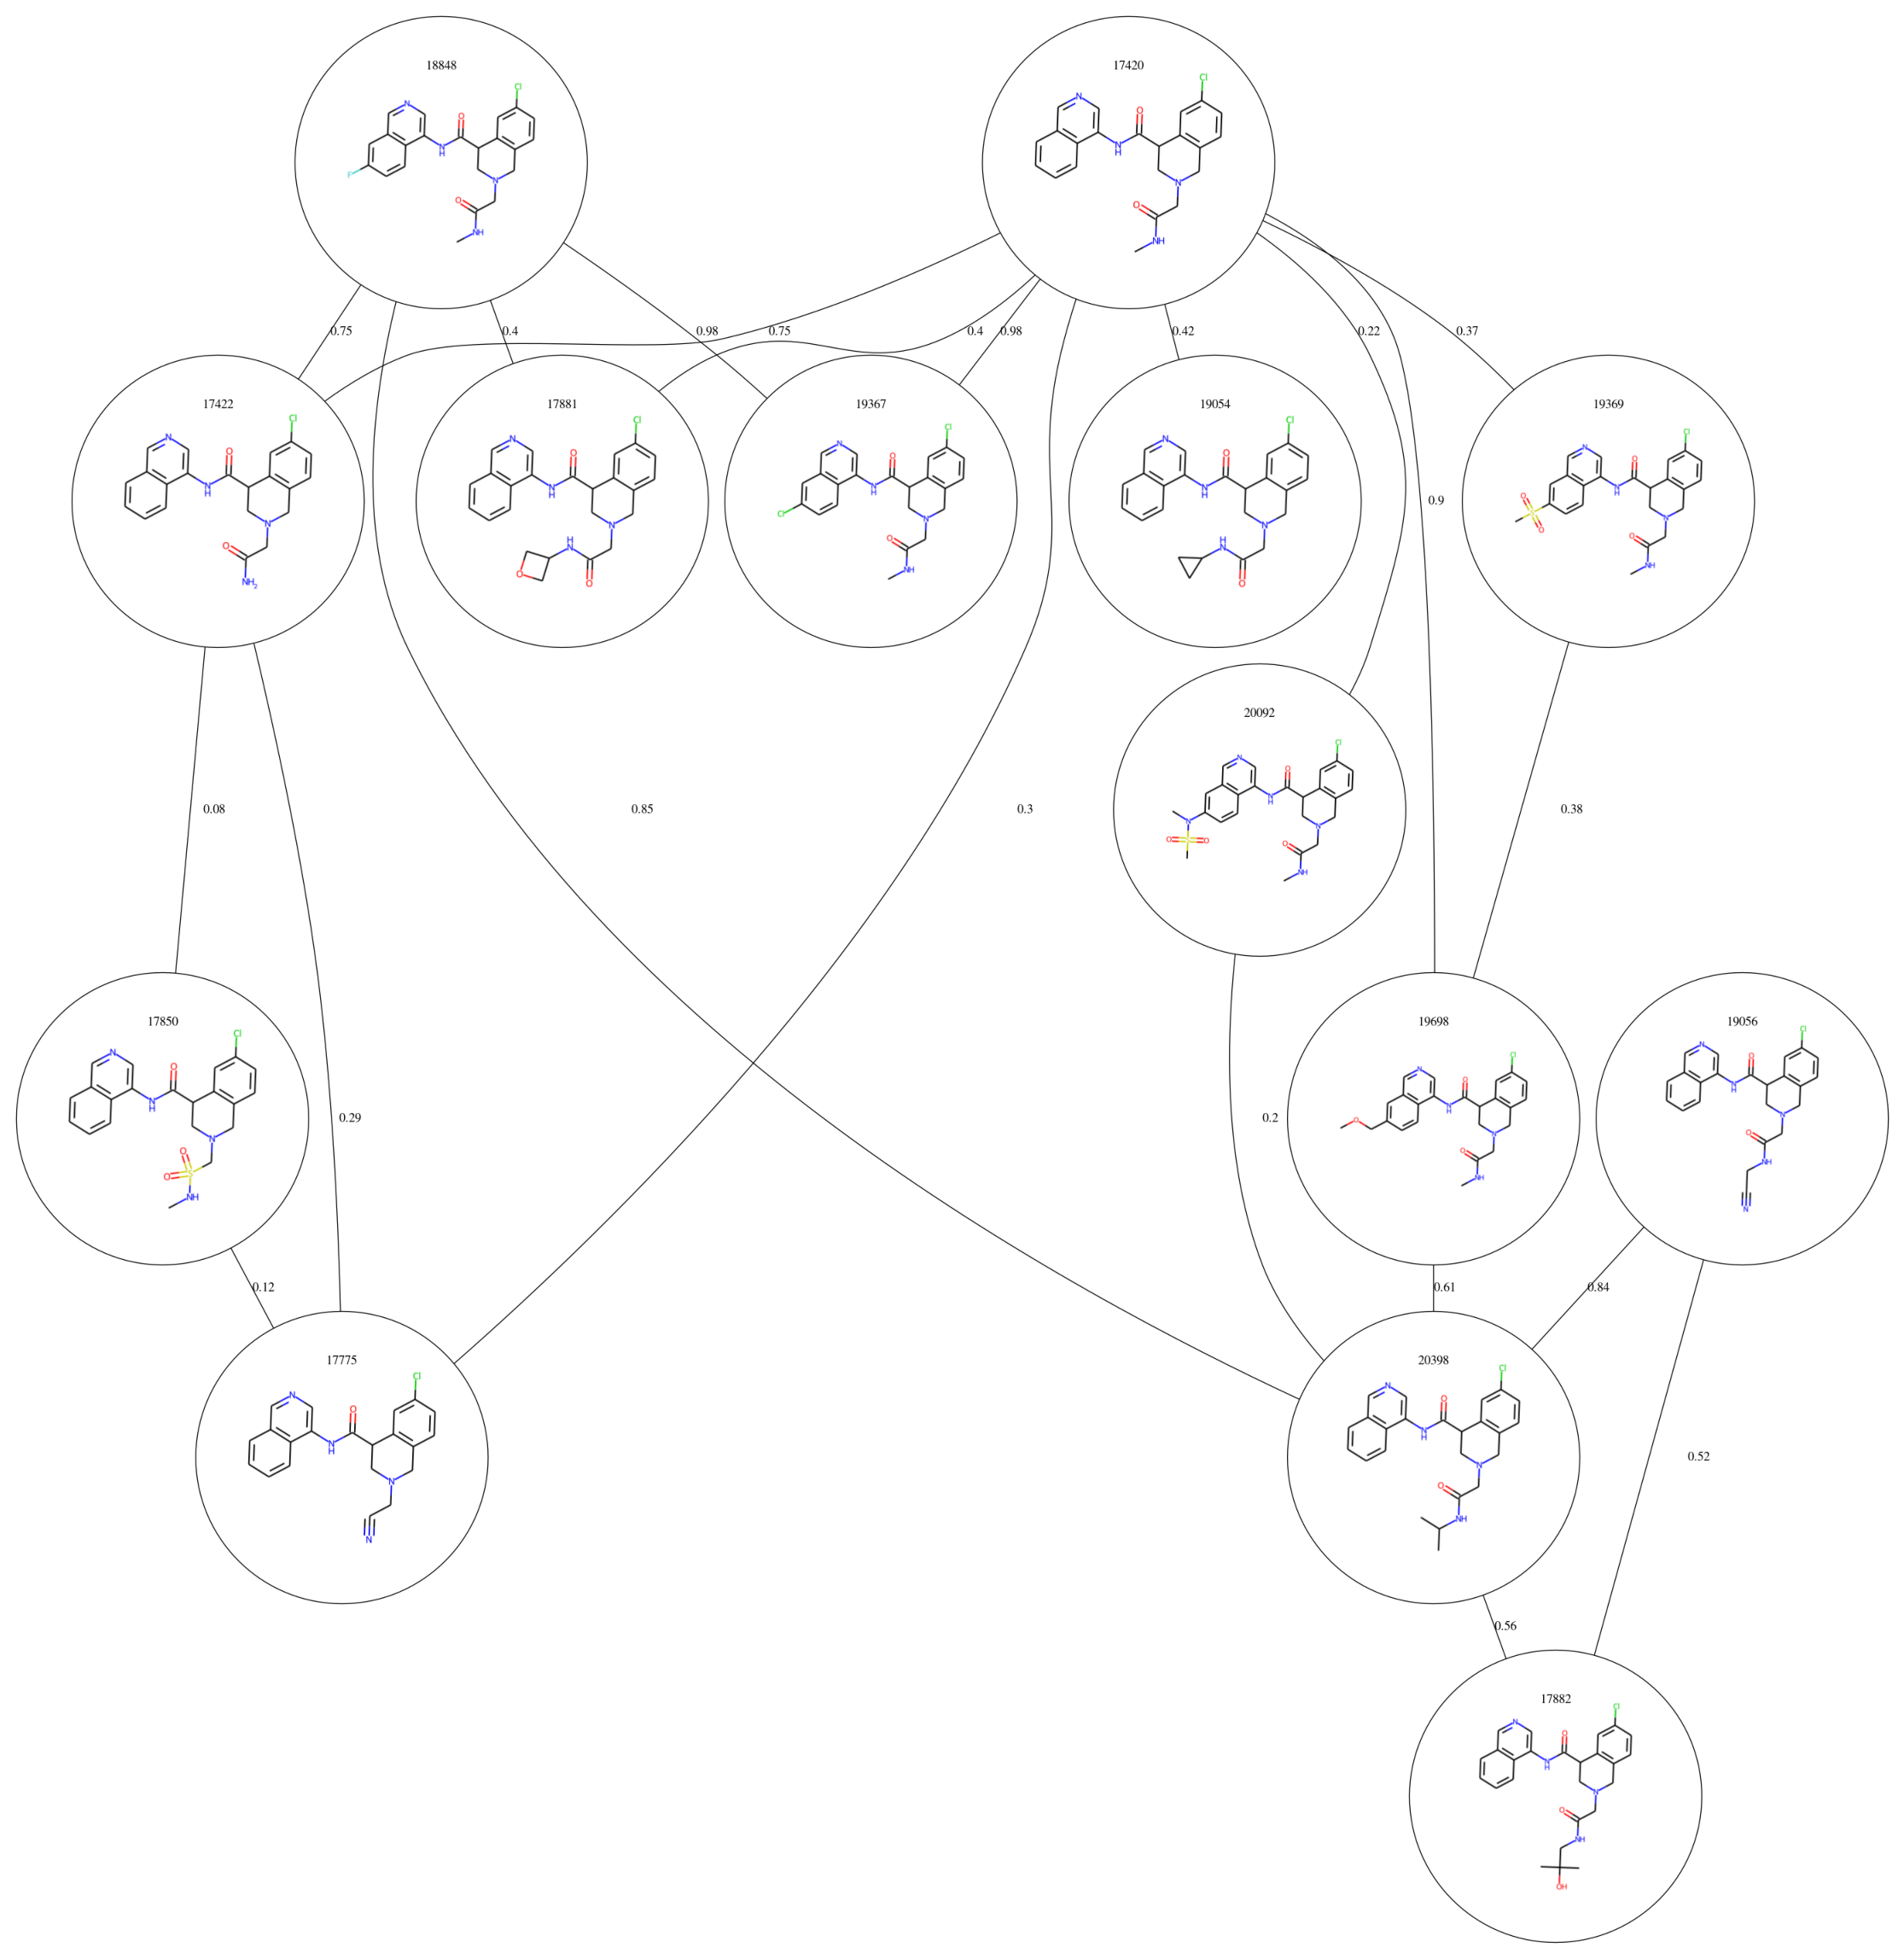

In [22]:
# generate the RBFENN network.
#Changed names=ligand_names to names=list(ligand_names_dict.values())

rbfenn_tranformations, rbfenn_scores = BSS.Align.generateNetwork(ligands_rdkit, plot_network=True, names=ligand_names, 
                                                         work_dir=work_dir,
                                                         links_file=links_file_name
                                                        )
#Copy figure into molecules directory
shutil.copyfile(work_dir+"/images/network.png", network_directory+"figure_rbfenn_graph.png")

#Save RBFENN transformations and scores to file
with open(network_directory+"/rbfenn_network_output.txt", "w") as writefile:
    writer = csv.writer(writefile, delimiter =" ")
    for (a, b), c in zip(rbfenn_tranformations,rbfenn_scores):
        writer.writerow([a,b,c])

In [58]:
# Save network with true SEM scores, as opposed to the scaled scores
"""
Useful output file of form
"transformations" define the connected edges of network. index is enumerated. (t1, t2)
idx is the molecule index, corresponding to row molecule appears in df
t1, t2, idx1, idx2, scaled SEM, true SEM
"""

# There will be a much better way to do this
# Dictionary probably already exists above
# If not, create a new dictionary of transformations above with true SEM, as opposed to this parsing task
import re
pert_sem_dict = {}
for (x,y),z in zip(true_perts,true_sems):
    a = re.split('[_.]', x)[1]
    b = re.split('[_.]', y)[1]
    index_string = a+"_"+b
    pert_sem_dict[index_string] = z


#Save RBFENN transformations and scores to file
with open(network_directory+"/rbfenn_network_output_useful.txt", "w") as writefile:
    writer = csv.writer(writefile, delimiter =" ")
    for (t1, t2), score_scaled in zip(rbfenn_tranformations,rbfenn_scores):
        idx1 = id_to_ligand_dict[t1]
        idx2 = id_to_ligand_dict[t2]
        score_sem = pert_sem_dict[f"{idx1}_{idx2}"]
        writer.writerow([t1,t2,idx1,idx2,score_scaled, score_sem])

# Generate Naive LOMAP Network

In [ ]:
from tqdm.notebook import tqdm, trange

In [ ]:
# BSS align function

mol_paths = glob.glob(f"{path_to_cluster}*.mol2")

ligands_BSS = [BSS.IO.readMolecules(x).getMolecule(0) for x in mol_paths]
ligand_names_BSS = [getLigName(x).split(".")[0] for x in mol_paths]

In [ ]:
for i in trange(1,len(ligands_BSS)):
    mapping = BSS.Align.matchAtoms(ligands_BSS[i], ligands_BSS[0])
    ligands_BSS[i] = BSS.Align.rmsdAlign(ligands_BSS[i], ligands_BSS[0], mapping)

In [ ]:
"""
import pandas as pd

df = pd.read_csv(f"{path_to_cluster}cluster.csv", index_col="index")

ligand_names_2 = [str(x) for x in list(df.index)]
ligand_smiles_2 = list(df.SMILES)
work_dir = network_directory+"runner_work_dir"
ligands_rdkit_2 = [Chem.MolFromSmiles(x) for x in ligand_smiles_2]
"""

In [ ]:
# generate the naive LOMAP network.

#import glob
#ligands_rdkit = [Chem.SDMolSupplier(x)[0] for x in glob.glob(f"{path_to_cluster}*.mol2")]
#ligand_names = [getLigName(x) for x in glob.glob(f"{path_to_cluster}*.mol2")]


##############################

lomap_tranformations, lomap_scores = BSS.Align.generateNetwork(ligands_BSS, plot_network=True, names=ligand_names_BSS, 
                                                         work_dir=work_dir, # NB: if using this, make sure the folder doesn't already exist!
                                                         #links_file=links_file_name
                                                        )
#Copy figure into molecules directory
shutil.copyfile(work_dir+"/images/network.png", network_directory+"figure_lomap_graph.png")

#Save LOMAP transformations and scores to file
with open(network_directory+"/lomap_network_output.txt", "w") as writefile:
    writer = csv.writer(writefile, delimiter =" ")
    for (a, b), c in zip(lomap_tranformations,lomap_scores):
        writer.writerow([a,b,c])

In [ ]:
"""
#Do ALl

for dir_number in range(0,1):
    MoleculesDirectory = f"clusters/cluster_m3_feat_{dir_number}/"
    cluster_pairs_input = MoleculesDirectory+"cluster_pairs.csv"
    sem_predictions = MoleculesDirectory+"cluster_pair_preds.csv"

    from itertools import combinations # handy function to create pairs of items in lists.

    ligand_file_paths = glob.glob(f"{MoleculesDirectory}*.sdf")
    with open(cluster_pairs_input, "w") as writefile:
        writer = csv.writer(writefile)

        # first get all combinations of ligands paths.
        all_pairs = list(combinations(ligand_file_paths, 2))

        # loop over the pairs while writing out lines.
        for a, b in all_pairs:
            writer.writerow([a, b])

            # also write the inverse pair, itertools.combinations only grabs A->B.
            writer.writerow([b, a])

    os.system(f'python predict_sf.py -i {cluster_pairs_input} -o {sem_predictions}')

    links_file_name = MoleculesDirectory+"links_file.in"
    work_dir = MoleculesDirectory+"runner_work_dir"
    # first clean up if needed. BSS seems to mess up if some files are already there when it starts the below procedure.
    if os.path.exists(work_dir) and os.path.isdir(work_dir):
        shutil.rmtree(work_dir)

    if os.path.exists(links_file_name):
        os.remove(links_file_name)

    import glob
    ligands_rdkit = [Chem.SDMolSupplier(x)[0] for x in glob.glob(f"{MoleculesDirectory}*.sdf")]
    ligand_names = [getLigName(x) for x in glob.glob(f"{MoleculesDirectory}*.sdf")]

    # add indexing to ligand_names as a dict.
    ligand_names_dict = {}
    for i, lig in enumerate(ligand_names):
        i = "{0:0=3d}".format(i) # make the indexing have 3 digits, i.e. 001, 002, 003 etc.
        ligand_names_dict[lig] = f"{i}_{lig}.sdf"

    true_perts = []
    true_sems = []

    with open(sem_predictions, "r") as readfile:
        reader = csv.reader(readfile)
        next(reader)
        # parse the SEM predictions file. Put the relevant data into separate lists.
        for row in reader:
            true_perts.append([ligand_names_dict[getLigName(row[0])], ligand_names_dict[getLigName(row[1])]])
            true_sems.append(float(row[-1]))
    # scale the SEM predictions to fit the LOMAP-Score form.
    true_sems = scaleArray(true_sems)

    with open(links_file_name, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        # write a 'links file' that contains all combinations of 
        # ligands and their SEM scores (that will replace LOMAP-Score.)
        for (a,b), value in zip(true_perts, true_sems):
            writer.writerow([a, b, value])


    rbfenn_tranformations, rbfenn_scores = BSS.Align.generateNetwork(ligands_rdkit, plot_network=True, names=ligand_names, 
                                                             work_dir=work_dir,
                                                             links_file=links_file_name
                                                            )
    #Copy figure into molecules directory
    shutil.copyfile(work_dir+"/images/network.png", MoleculesDirectory+"figure_rbfenn_graph.png")

    #Save RBFENN transformations and scores to file
    with open(MoleculesDirectory+"/rbfenn_network_output.txt", "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        for (a, b), c in zip(rbfenn_tranformations,rbfenn_scores):
            writer.writerow([a,b,c])


    lomap_tranformations, lomap_scores = BSS.Align.generateNetwork(ligands_rdkit, plot_network=True, names=ligand_names, 
                                                             work_dir=work_dir, # NB: if using this, make sure the folder doesn't already exist!
                                                             #links_file=links_file_name
                                                            )
    #Copy figure into molecules directory
    shutil.copyfile(work_dir+"/images/network.png", MoleculesDirectory+"figure_lomap_graph.png")

    #Save LOMAP transformations and scores to file
    with open(MoleculesDirectory+"/lomap_network_output.txt", "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        for (a, b), c in zip(lomap_tranformations,lomap_scores):
            writer.writerow([a,b,c])
"""

In [ ]:
ligands_BSS

In [ ]:
cluster_dir_name = "cls-22-06-27-2-aligned/"
path_to_cluster = f"clusters/{cluster_dir_name}"

network_directory = f"networks/{cluster_dir_name}"
cluster_pairs_input = f"{network_directory}cluster_pairs.csv"
sem_predictions = f"{network_directory}cluster_pair_preds.csv"

In [ ]:
for name, mol in zip(ligand_names_BSS, ligands_BSS):
    BSS.IO.saveMolecules(path_to_cluster+name, mol, "mol2")